0.25


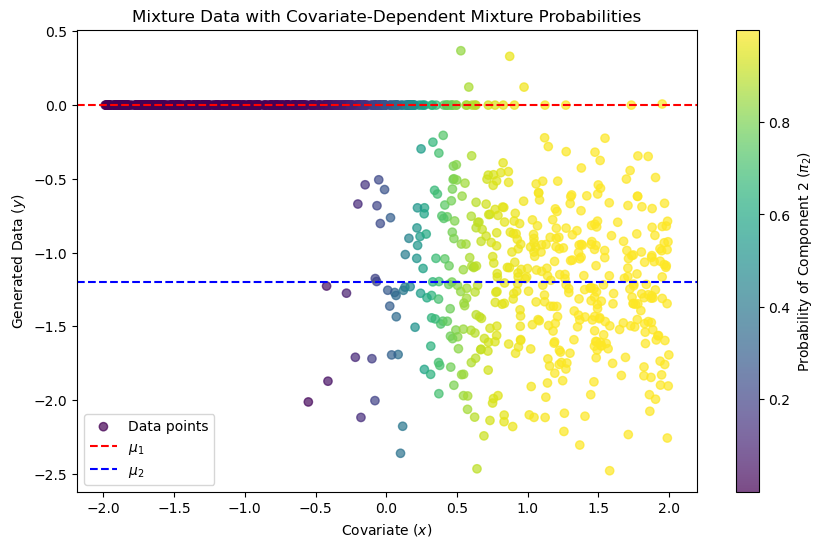

In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
import random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


n_samples =1000
a, b = 5.0, -1.0  # Coefficients for logistic regression to control mixture probabilities
mu_1, sigma_1_sq = 0.0, 0.2
mu_2, sigma_2_sq = -1.20,  0.5


print(sigma_2_sq   **2 )

sebetahat= np.random.uniform( 0.1, 0.5, n_samples)
# Covariates
x = np.random.uniform(-2, 2, n_samples)

# Mixture probabilities
pi_2 = 1 / (1 + np.exp(-(a * x + b)))  # Sigmoid function for covariate-dependent pi_2
pi_1 = 1 - pi_2  # Ensure pi_1 + pi_2 = 1

# Generate data
y = np.zeros(n_samples)
betahat = np.zeros(n_samples)
c = np.zeros(n_samples, dtype=int)  # Ensure c is an integer array
for i in range(n_samples):
    # Use .item() to extract the scalar from np.random.choice
    c[i] = np.random.choice([0, 1], p=[pi_1[i], pi_2[i]])
    if c[i] == 0:
        y[i] = 0
        betahat[i]= y[i]+ np.random.normal(0, sebetahat[i] )
    else:
        y[i] = np.random.normal(mu_2,  sigma_2_sq   )
        betahat[i]= y[i]+ np.random.normal(0,   sebetahat[i] )


# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2, cmap='viridis', label='Data points', alpha=0.7)
plt.colorbar(label='Probability of Component 2 ($\pi_2$)')
plt.axhline(mu_1, color='red', linestyle='--', label='$\mu_1$')
plt.axhline(mu_2, color='blue', linestyle='--', label='$\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities')
plt.legend()
plt.show()


In [2]:
np.var(y)

0.4676351339715219

In [3]:
np.var(betahat)

0.5930365738371323

In [4]:
0.2**2+0.5**2

0.29000000000000004

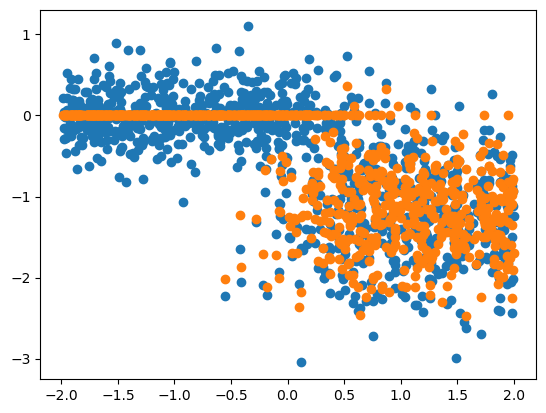

In [5]:

plt.scatter(x,betahat)
 
plt.scatter(x,y)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MDN model
class MDN(nn.Module):
    def __init__(self, input_dim):
        super(MDN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # Output: logit for pi_2
        )
        self.mu_1 = 0.0  # Fixed mean for component 1
        self.sigma_1_sq = 0.0  # Fixed variance for component 1
        self.mu_2 = nn.Parameter(torch.tensor(0.0))  # Learnable mean for component 2

    def forward(self, x):
        logit_pi2 = self.fc(x).squeeze()
        pi_2 = torch.sigmoid(logit_pi2)
        pi_1 = 1 - pi_2
        return pi_1, pi_2, self.mu_2


# Loss function: Negative Log Likelihood
def mdn_loss(pi_1, pi_2, mu_2, sigma_2_sq, targets, sd_noise):
    mu_1 = torch.tensor(0.0)
    sigma_1_sq_total = sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets - mu_1) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    mixture_pdf = pi_1 * p1 + pi_2 * p2
    return -torch.mean(torch.log(mixture_pdf + 1e-8))


# Compute responsibilities (gamma values) for component 2
def compute_responsibilities(pi_1, pi_2,   mu_2, sigma_2_sq, targets, sd_noise):
    sigma_1_sq_total =0 + sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets ) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    return (pi_2 * p2) / (pi_1 * p1 + pi_2 * p2)
  
# Perform the M-step to update sigma_2^2
def m_step_sigma2(gamma_2, mu_2, targets, sd_noise):
    residuals_sq = (targets - mu_2) ** 2
    sigma_0_sq = sd_noise**2
    numerator = torch.sum(( gamma_2 )* (residuals_sq - sigma_0_sq))
    denominator = torch.sum(( gamma_2 ))
    return torch.clamp(numerator / denominator, min=1e-6)


# Generate training data
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(betahat, dtype=torch.float32)
obs_sd_noise = torch.tensor(sebetahat, dtype=torch.float32)

# Initialize model and optimizer
model = MDN(input_dim=1)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.01)

# Training loop
n_epochs = 1000
sigma_2_sqe = torch.tensor(1, requires_grad=False)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    pi_1, pi_2, mu_2e = model(x_tensor)

    gamma_2 = compute_responsibilities(
        pi_1=pi_1, pi_2=pi_2,
       
        mu_2=mu_2e, 
        sigma_2_sq=sigma_2_sqe,
        targets=y_tensor,
        sd_noise=obs_sd_noise
    ) 
    with torch.no_grad():
        sigma_2_sqe = m_step_sigma2( gamma_2, mu_2e, y_tensor, obs_sd_noise)

    loss = mdn_loss(pi_1, pi_2, mu_2e, sigma_2_sqe, y_tensor, obs_sd_noise)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Sigma_2^2: {sigma_2_sqe.item()}")

# Evaluation



Epoch 0, Loss: 1.2977923154830933, Sigma_2^2: 1.4121791124343872
Epoch 100, Loss: 0.6022994518280029, Sigma_2^2: 0.3382906913757324
Epoch 200, Loss: 0.5657563805580139, Sigma_2^2: 0.23360438644886017
Epoch 300, Loss: 0.5655432939529419, Sigma_2^2: 0.23374193906784058
Epoch 400, Loss: 0.5651279091835022, Sigma_2^2: 0.23368299007415771
Epoch 500, Loss: 0.5649402737617493, Sigma_2^2: 0.2341352254152298
Epoch 600, Loss: 0.5648475289344788, Sigma_2^2: 0.2342730015516281
Epoch 700, Loss: 0.5646734833717346, Sigma_2^2: 0.23449620604515076
Epoch 800, Loss: 0.5645217895507812, Sigma_2^2: 0.23461677134037018
Epoch 900, Loss: 0.5643916130065918, Sigma_2^2: 0.23499180376529694


In [7]:
model.eval()
with torch.no_grad():
    pi_1, pi_2, mu_2e = model(x_tensor)

pi_np = pi_2.detach().numpy()
mu_2e= mu_2e.detach().numpy()
sigma_prior = np.sqrt(sigma_2_sqe.detach().numpy())/2


post_mean = np.zeros_like(betahat)
post_var = np.zeros_like(betahat)
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from posterior_computation import *

for i in range(len(betahat)):
        post_mean[i], post_var[i] = posterior_point_mass_normal(
            betahat=betahat[i],
            sebetahat=sebetahat[i],
            pi=( 1-pi_np[i]),  # Scalar pi for each observation
            mu0=0,  # Fixed mean for the point mass
            mu1=mu_2e,  # Global parameter
            sigma_0=sigma_prior  # Global parameter
            )
post_mean2= post_var+ post_mean**2 

In [8]:
posterior_point_mass_normal(
            betahat=betahat[i],
            sebetahat=sebetahat[i],
            pi=( pi_np[i]),  # Scalar pi for each observation
            mu0=0,  # Fixed mean for the point mass
            mu1=mu_2e,  # Global parameter
            sigma_0=sigma_prior  # Global parameter
            )

(-0.7487587721581503, 0.03346808554158119)

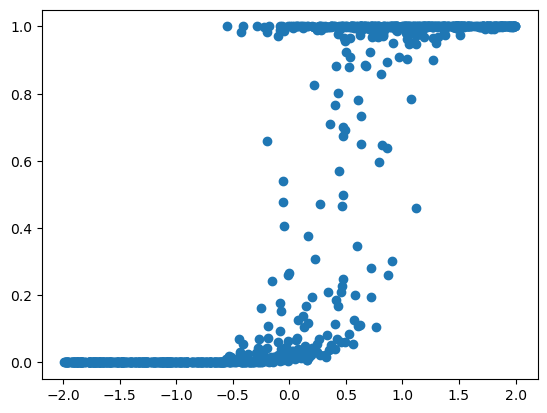

In [9]:
plt.scatter(x,gamma_2.detach().numpy() )

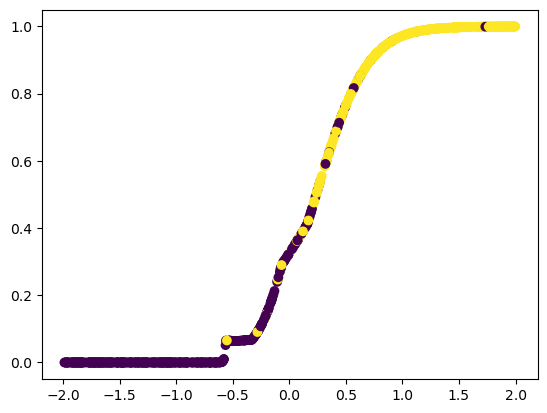

In [10]:
plt.scatter(x,pi_2.detach().numpy(), c=c )

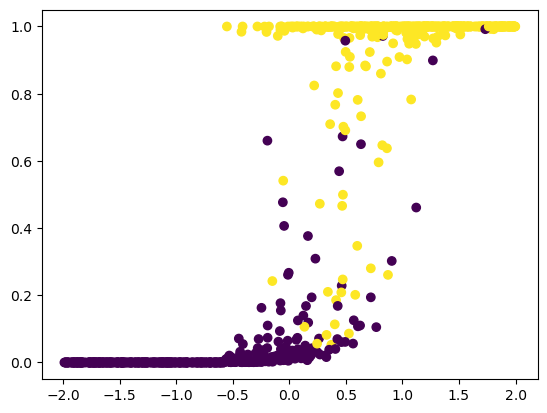

In [11]:
plt.scatter(x,gamma_2.detach().numpy(), c=c )

In [12]:
gamma_2.detach().numpy() 

array([4.56232023e-33, 1.18853264e-01, 9.99086201e-01, 9.99993622e-01,
       1.00000000e+00, 9.99999642e-01, 1.05155103e-01, 9.99998510e-01,
       3.75332218e-22, 9.86971915e-01, 4.17631630e-27, 9.99876857e-01,
       9.99799550e-01, 0.00000000e+00, 6.46609187e-01, 1.00000000e+00,
       7.08458553e-34, 2.35364940e-02, 1.00000000e+00, 0.00000000e+00,
       5.95570922e-01, 1.17381919e-14, 9.99537468e-01, 1.00000000e+00,
       9.99980927e-01, 2.12491229e-02, 1.00000000e+00, 9.98872519e-01,
       1.23705102e-10, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.66877189e-25, 0.00000000e+00, 0.00000000e+00, 9.76439834e-01,
       2.08456882e-07, 1.00000000e+00, 0.00000000e+00, 6.08306114e-11,
       8.18316266e-03, 9.98808563e-01, 1.39379003e-11, 9.99436259e-01,
       1.00000000e+00, 2.28547841e-01, 1.18002745e-25, 0.00000000e+00,
       9.99999702e-01, 0.00000000e+00, 9.98342276e-01, 1.00000000e+00,
       9.99998450e-01, 9.70081270e-01, 9.99998391e-01, 3.53639247e-04,
      

In [13]:
tt= (betahat-mu_2)**2

print(sum(( gamma_2.detach().numpy()* (tt))))
print(sum(gamma_2.detach().numpy()* (sebetahat**2)))
sum(gamma_2.detach().numpy())

159.39833696401158
48.413702564786874


466.3748445221878

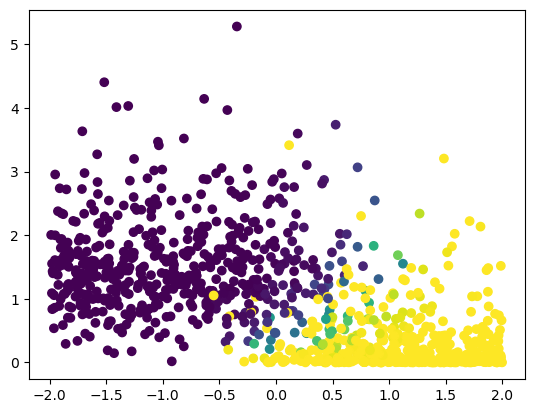

In [14]:
plt.scatter(x,tt,c=gamma_2.detach().numpy() )


In [15]:
sigma_2_sq**2

0.25

In [16]:
sigma_2_sqe.detach().numpy()

array(0.23560885, dtype=float32)

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

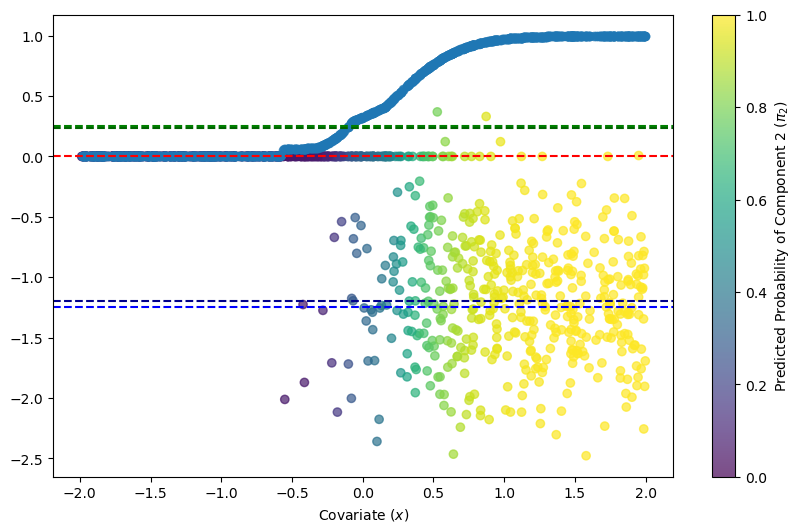

In [17]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2.numpy(), cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x, pi_2,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(mu_2e , color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(mu_2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.axhline(sigma_2_sq   **2 , color='green', linestyle='--', label='Predicted $\mu_2$')

plt.axhline( sigma_2_sqe.detach().numpy(), color='darkgreen', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


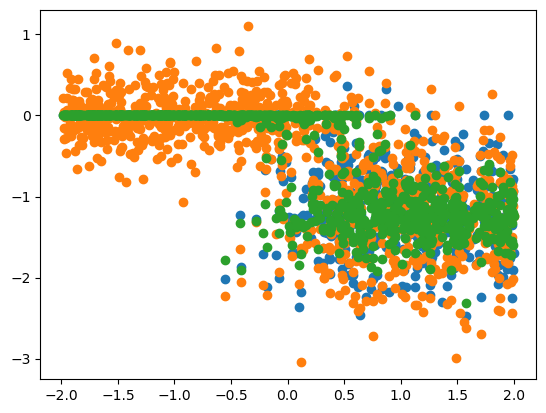

In [18]:
plt.scatter(x, y)
plt.scatter(x,betahat
            )
plt.scatter(x, post_mean)


(array([500.,  18.,  10.,   4.,   6.,   3.,   6.,   6.,   9., 438.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

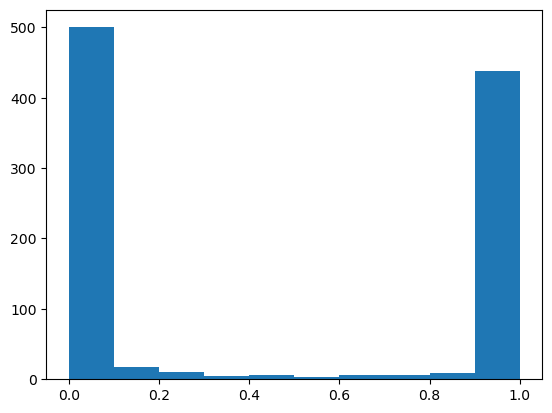

In [19]:
plt.hist(gamma_2.detach().numpy() )

In [20]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from empirical_mdn import *
from covaraite_moderated_generalized_binary import *

In [21]:
res = cgb_posterior_means(x, betahat, sebetahat)

Epoch 0, Loss: 1.2812105417251587, Sigma_2^2: 1.4886653423309326


In [22]:
mu_2

-1.2

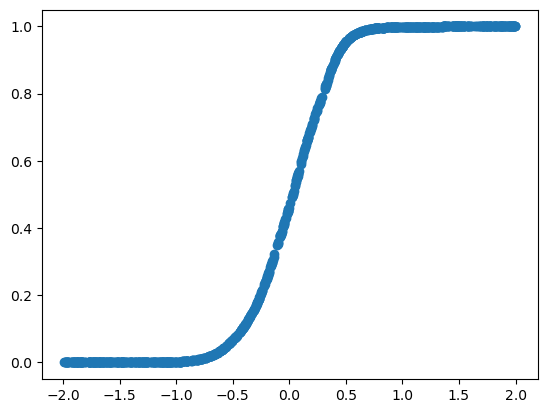

In [23]:
plt.scatter(x, res.pi)

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

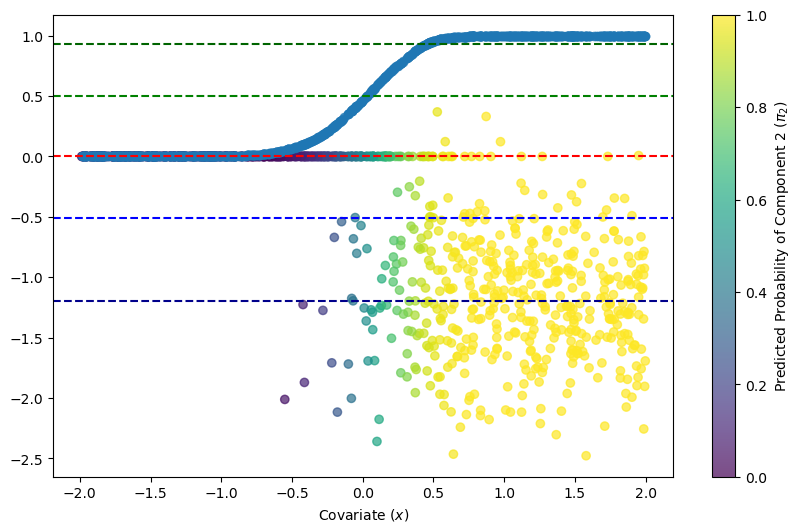

In [24]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c= res.pi, cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x,  res.pi,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(res.mu_1 , color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(mu_2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.axhline(sigma_2_sq    , color='green', linestyle='--', label='Predicted $\mu_2$')

plt.axhline( np.sqrt( res.sigma_0 ), color='darkgreen', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


In [25]:
res.mu_1

array(-0.511206, dtype=float32)

In [26]:
mu_2

-1.2

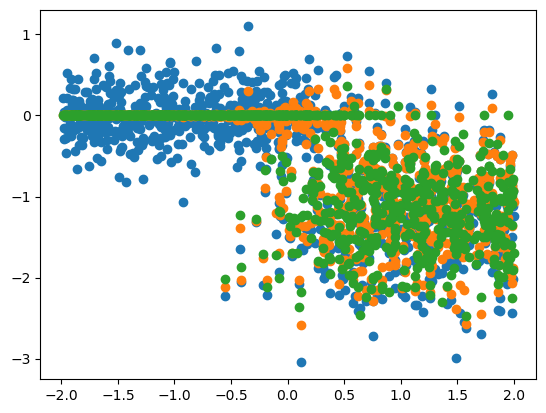

In [27]:
plt.scatter(x,betahat
            )
plt.scatter(x, res.post_mean)
plt.scatter(x, y)

In [28]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from empirical_mdn import *
from hard_covaraite_moderated_generalized_binary import *

In [29]:
res = cgb_hard_posterior_means(x, betahat, sebetahat)

Epoch 0, Loss: 4.699397087097168 


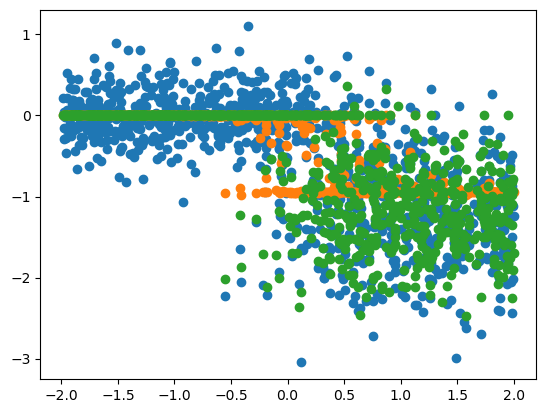

In [30]:
plt.scatter(x,betahat
            )
plt.scatter(x, res.post_mean)
plt.scatter(x, y)